In [37]:
import numpy as np
import matplotlib.pyplot as plt

In [38]:
from loaders import clean_text_for_pattern_letter
from temp_text import template_str
input_str = clean_text_for_pattern_letter(template_str, out_len=500)
print(len(input_str))
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
               'v', 'w', 'x', 'y', 'z', ' ', '.', ',', '"', '\'', '1']
print(f'{letters=}')

len(letters)=32
500
letters=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '.', ',', '"', "'", '1']


In [39]:
# train
max_index = 16

next_index: dict[str, int] = {}
index_by_prev: dict[str, dict] = {}

StatsDict: dict[str, dict] = {}

for letter in letters:
    next_index[letter] = 1

for inp_idx, inp in enumerate(input_str):
    if inp_idx <= 0 or inp_idx == len(input_str) - 1:
        continue

    prev_idx = inp_idx - 1
    prev_inp = input_str[prev_idx]
    
    inp_index = next_index[inp]

    prev_index = next_index[prev_inp]

    stats_key = prev_inp + str(prev_index) + ':' + inp + str(inp_index)
    StatsDict.setdefault(stats_key, {})

    next_inp = input_str[inp_idx + 1]
    StatsDict[stats_key].setdefault(next_inp, 0)

    StatsDict[stats_key][next_inp] += 1

    by_prev_key = prev_inp + str(prev_index) + ':' + inp
    index_by_prev.setdefault(by_prev_key, {})
    index_by_prev[by_prev_key].setdefault(inp_index, 0)
    index_by_prev[by_prev_key][inp_index] += 1

    by_prev_key = prev_inp + str(0) + ':' + inp
    index_by_prev.setdefault(by_prev_key, {})
    index_by_prev[by_prev_key].setdefault(inp_index, 0)
    index_by_prev[by_prev_key][inp_index] += 1

    # next_index[inp] += 1
    # if next_index[inp] > max_index:
    #     next_index[inp] = 1
    
    next_index[prev_inp] += 1
    if next_index[prev_inp] > max_index:
        next_index[prev_inp] = 1


In [40]:
for sdk, sdv in index_by_prev.items():
    print(sdk, sdv)
    print('')

t1:h {1: 1}

t0:h {1: 1, 2: 2, 3: 1, 9: 1, 11: 1, 12: 1, 13: 1, 15: 1, 16: 1, 5: 1}

h1:e {1: 1}

h0:e {1: 1, 3: 2, 4: 2, 12: 2, 15: 1, 2: 2, 14: 2, 8: 1}

e1:  {1: 1}

e0:  {1: 1, 3: 1, 4: 3, 7: 2, 2: 2, 5: 2, 10: 1, 15: 1, 8: 1, 13: 1, 9: 2}

 1:s {1: 1}

 0:s {1: 1, 7: 1, 8: 1, 10: 1, 2: 1, 3: 1}

s1:k {1: 1}

s0:k {1: 1}

k1:y {1: 1}

k0:y {1: 1}

y1:  {2: 1}

y0:  {2: 1, 13: 1, 9: 1, 7: 1}

 2:a {1: 1}

 0:a {1: 2, 3: 2, 9: 1, 11: 2, 15: 1, 2: 1, 6: 1, 12: 1, 4: 1}

a1:b {1: 1}

a0:b {1: 1}

b1:o {1: 1}

b0:o {1: 1, 2: 1, 6: 1}

o1:v {1: 1}

o0:v {1: 1}

v1:e {2: 1}

v0:e {2: 1, 7: 2, 9: 1}

e2:  {3: 1, 15: 1}

 3:t {2: 1, 6: 1}

 0:t {2: 2, 4: 1, 5: 1, 6: 2, 7: 2, 10: 1, 11: 1, 12: 1, 13: 1, 16: 1, 9: 1}

t2:h {2: 1, 16: 1}

h2:e {3: 1, 2: 1}

e3:  {4: 2, 2: 1}

 4:p {1: 1}

 0:p {1: 1, 5: 1, 8: 1}

p1:o {2: 1}

p0:o {2: 1}

o2:r {1: 1}

o0:r {1: 1, 2: 2, 8: 1, 13: 1, 5: 1}

r1:t {3: 1}

r0:t {3: 1}

t3:  {5: 1}

t0:  {5: 1, 1: 1, 16: 1}

 5:w {1: 1}

 0:w {1: 1, 2: 1, 4: 1, 7: 1

In [41]:
for sdk, sdv in StatsDict.items():
    print(sdk, sdv)
    print('')

t1:h1 {'e': 1}

h1:e1 {' ': 1}

e1: 1 {'s': 1}

 1:s1 {'k': 1}

s1:k1 {'y': 1}

k1:y1 {' ': 1}

y1: 2 {'a': 1}

 2:a1 {'b': 1}

a1:b1 {'o': 1}

b1:o1 {'v': 1}

o1:v1 {'e': 1}

v1:e2 {' ': 1}

e2: 3 {'t': 1}

 3:t2 {'h': 1}

t2:h2 {'e': 1}

h2:e3 {' ': 1}

e3: 4 {'p': 1, 'f': 1}

 4:p1 {'o': 1}

p1:o2 {'r': 1}

o2:r1 {'t': 1}

r1:t3 {' ': 1}

t3: 5 {'w': 1}

 5:w1 {'a': 1}

w1:a2 {'s': 1}

a2:s2 {' ': 1}

s2: 6 {'t': 1}

 6:t4 {'h': 1}

t4:h3 {'e': 1}

h3:e4 {' ': 1}

e4: 7 {'c': 1}

 7:c1 {'o': 1}

c1:o3 {'l': 1}

o3:l1 {'o': 1}

l1:o4 {'r': 1}

o4:r2 {' ': 1}

r2: 8 {'o': 1}

 8:o5 {'f': 1}

o5:f1 {' ': 1}

f1: 9 {'t': 1}

 9:t5 {'e': 1}

t5:e5 {'l': 1}

e5:l2 {'e': 1}

l2:e6 {'v': 1}

e6:v2 {'i': 1}

v2:i1 {'s': 1}

i1:s3 {'i': 1}

s3:i2 {'o': 1}

i2:o6 {'n': 1}

o6:n1 {',': 1}

n1:,1 {' ': 1}

,1: 10 {'t': 1}

 10:t6 {'u': 1}

t6:u1 {'n': 1}

u1:n2 {'e': 1}

n2:e7 {'d': 1}

e7:d1 {' ': 1}

d1: 11 {'t': 1}

 11:t7 {'o': 1}

t7:o7 {' ': 1}

o7: 12 {'a': 1}

 12:a3 {' ': 1}

a3: 13 {'d

In [42]:
# infer
for letter in letters:
    next_index[letter] = 0

TF = []
TF_2 = []
TF_3 = []

err = 0

prev_index_l = [x for x in range(1, max_index+1)]

for inp_idx, inp in enumerate(input_str):
    if inp_idx <= 0 or inp_idx == len(input_str) - 1:
        continue

    prev_inp = input_str[inp_idx - 1]
    
    index_l = []
    stats_d = {}
    index_d = {}
    for prev_index in prev_index_l:
        by_prev_key = prev_inp + str(prev_index) + ':' + inp
        # print(by_prev_key)
        inp_index_arr = index_by_prev.get(by_prev_key, {-1: -1})
        # print(inp_index_arr)

        for inp_index, val in inp_index_arr.items():
            if inp_index != -1:
                index_d.setdefault(inp_index, 0)
                index_d[inp_index] += val

            if inp_index != -1 and index_l.__contains__(inp_index) == False:
                index_l.append(inp_index)

                stats_key = prev_inp + str(prev_index) + ':' + inp + str(inp_index)
                stats = StatsDict.get(stats_key, {})

                next_inp = input_str[inp_idx + 1]
                # print(next_inp, stats_key, stats)
                for st_key, st in stats.items():
                    stats_d.setdefault(st_key, 0)
                    stats_d[st_key] += 1

    max_key_d = max(index_d, key=index_d.get)
    if inp == prev_inp:
        pred_max_key = max_key_d
        max_key_d += 1
        if max_key_d > max_index:
            max_key_d = 1
        
        index_d[max_key_d] = index_d[pred_max_key]
        index_d.pop(pred_max_key)

    prev_index_l = list(index_d.keys())

    if len(stats_d) > 0:
        max_key = max(stats_d, key=stats_d.get)
        print(max_key, next_inp, stats_d, index_l, index_d, prev_index_l, inp == prev_inp)
    
    if max_key != next_inp:
        err += 1

    tf = sum(stats_d.values())
    TF.append(tf)
    tf = len(stats_d.values())
    TF_2.append(tf)
    tf = len(index_l)
    TF_3.append(tf)

print(err, err / (len(input_str) / 100) )

e e {'e': 8, 'r': 1, 'i': 1} [1, 2, 16, 3, 9, 5, 11, 12, 13, 15] {1: 1, 2: 2, 16: 1, 3: 1, 9: 1, 5: 1, 11: 1, 12: 1, 13: 1, 15: 1} [1, 2, 16, 3, 9, 5, 11, 12, 13, 15] False
    {' ': 4, 'r': 1, 'a': 2, 't': 1} [1, 3, 2, 14, 4, 8, 12] {1: 1, 3: 2, 2: 2, 14: 1, 4: 2, 8: 1, 12: 2} [1, 3, 2, 14, 4, 8, 12] False
c s {'s': 2, 'p': 1, 'f': 2, 'd': 1, 't': 1, 'c': 3} [1, 4, 2, 3, 15, 7, 9, 5] {1: 1, 4: 3, 2: 1, 3: 1, 15: 1, 7: 2, 9: 2, 5: 1} [1, 4, 2, 3, 15, 7, 9, 5] False
k k {'k': 1, 'p': 1, 'a': 1} [1, 2, 8] {1: 1, 2: 1, 8: 1} [1, 2, 8] False
y y {'y': 1} [1] {1: 1} [1] False
    {' ': 1} [1] {1: 1} [1] False
a a {'a': 1} [2] {2: 1} [2] False
b b {'b': 1} [1] {1: 1} [1] False
o o {'o': 1} [1] {1: 1} [1] False
v v {'v': 1} [1] {1: 1} [1] False
e e {'e': 1} [1] {1: 1} [1] False
    {' ': 1} [2] {2: 1} [2] False
t t {'t': 1, 'c': 1} [3, 15] {3: 1, 15: 1} [3, 15] False
h h {'h': 2} [2, 6] {2: 1, 6: 1} [2, 6] False
e e {'e': 2} [2, 16] {2: 2, 16: 1} [2, 16] False
    {' ': 2, 'r': 1} [3, 2, 14] 

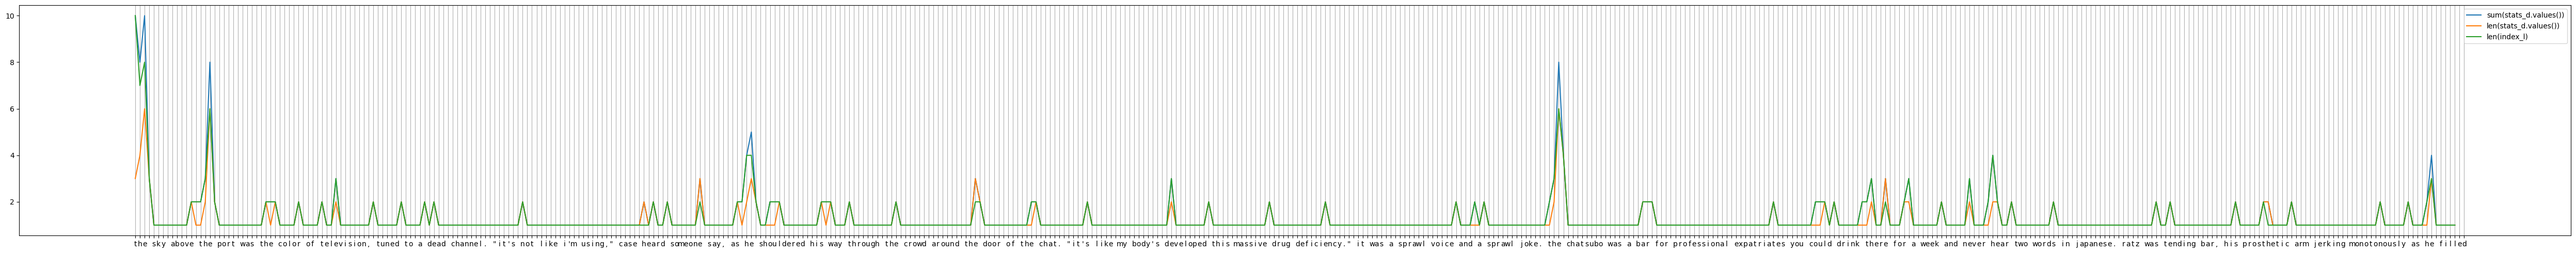

In [44]:
TF = np.array(TF, dtype=float)
# TF = TF - np.pad(TF, (1, 0))[:-1]
# # print(TF)
# TF[np.where(TF > 0)] = 0
# TF = np.abs(TF)
# TF[np.where(TF <= np.mean(TF))] = 0
# # TF[np.where(TF <= 0.5)] = 0
# print(TF.size, TF.max(), TF.min())

TF_2 = np.array(TF_2, dtype=float)
TF_3 = np.array(TF_3, dtype=float)

fig, axs = plt.subplots(1, 1, figsize=(50, 5), tight_layout=True)
axs.plot(np.arange(TF.size), TF, label='sum(stats_d.values())')
axs.plot(np.arange(TF_2.size), TF_2, label='len(stats_d.values())')
axs.plot(np.arange(TF_3.size), TF_3, label='len(index_l)')
axs.xaxis.set_ticks(np.arange(len(input_str)) ,input_str)
axs.xaxis.grid(True)

plt.legend()
plt.show()